<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/uncertainty/uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: https://medium.com/deeplearningmadeeasy/how-to-add-uncertainty-to-your-neural-network-afb5f855e66a

In [2]:
import torch
from torch import nn
from torch import optim
from torch import functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Create the dataset

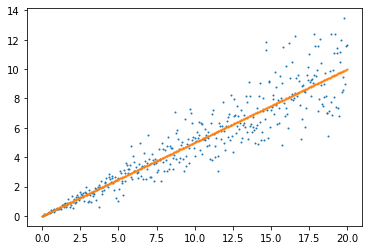

In [5]:

def create_dataset():
  x = np.arange(0,20,0.05)
  y = x * 0.5
  eplison = np.random.normal(0,0.5,(len(x)))
  y_noise = y + eplison *  x/5
  return x, y, y_noise

x,y,y_noise = create_dataset()

plt.scatter(x,y_noise,s=1)
plt.scatter(x,y,s=1)

In [14]:
#torch.from_numpy(x).float().shape #torch.Size([400])
#torch.from_numpy(x).float()[...,None] #torch.Size([400, 1])
def to_tensor(x):
  return torch.from_numpy(x).float().unsqueeze(1)

In [15]:
ratio = 0.7
split_idx = int(len(x)*ratio)
x_train = to_tensor(x[..., :split_idx])
x_test = to_tensor(x[..., split_idx:])
y_true_train = to_tensor(y[..., :split_idx])
y_true_test = to_tensor(y[..., split_idx:])
y_train = to_tensor(y_noise[..., :split_idx])
y_test = to_tensor(y_noise[..., split_idx:])

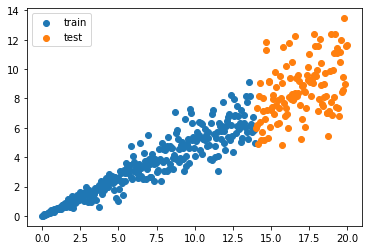

In [16]:
plt.scatter(x_train, y_train, label="train")
plt.scatter(x_test, y_test, label="test")
plt.legend()

plt.show()

In [31]:
#auhor: Christina
def train_model(model,loss_fn,optimizer,iterations=100,print_every=50,lr=0.001):
  optimizer.lr = lr

  for i in range(iterations):
    model.train()
    out = model(x_train)
    loss = loss_fn(y_train,out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % print_every == 0:
      with torch.no_grad():
        model.eval()
        out = model(x_test)
        test_loss = loss_fn(y_test,out)
        print(loss,test_loss)

In [27]:
def visualize_model(model):
    model.eval()
    plt.scatter(x_train, y_train)
    out = model(x_train).detach().numpy().squeeze()
    plt.scatter(x_train, y_true_train, label='Train_real')
    plt.scatter(x_train, out, label='Train_out')

    plt.scatter(x_test, y_test)
    out = model(x_test).detach().numpy().squeeze()
    plt.scatter(x_test, y_true_test, label='Test_real')
    plt.scatter(x_test, out, label='Test_out')
    plt.legend()

## Model with MSE loss

In [19]:
mse_model = nn.Sequential(
    nn.Linear(1,20),
    nn.LeakyReLU(0.3),
    nn.Linear(20,1)
)

mse_loss = nn.MSELoss()
adam = optim.Adam(params=mse_model.parameters(),lr=0.001)

In [ ]:
mse_model = nn.Sequential(
    nn.Linear(1, 20),
    nn.LeakyReLU(0.3),
    nn.Linear(20, 1),
)
mse_loss = nn.MSELoss()
adam = optim.Adam(params=mse_model.parameters(), lr=0.001)

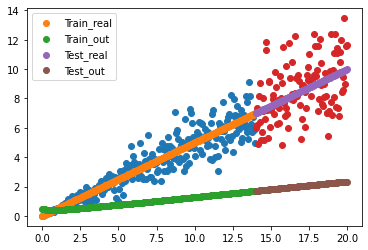

In [28]:
# just before training
visualize_model(mse_model)

tensor(9.3773, grad_fn=<MseLossBackward0>) tensor(44.8043)
tensor(0.6040, grad_fn=<MseLossBackward0>) tensor(3.0302)
tensor(0.6013, grad_fn=<MseLossBackward0>) tensor(3.0398)
tensor(0.5975, grad_fn=<MseLossBackward0>) tensor(3.0748)


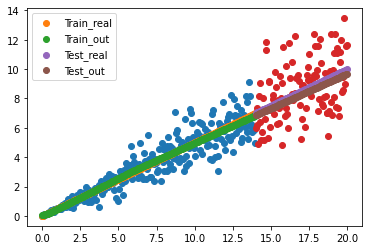

In [32]:
train_model(mse_model, mse_loss, adam, iterations=4000, print_every=1000)

# after training
visualize_model(mse_model)

## Probabilistic model with NLL loss

In [33]:
#auhor: Christina
class UncertaintyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.backbone = nn.Sequential(
        nn.BatchNorm1d(1), # trick to normalize the input automatically
        nn.Linear(1,3),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(3),
        nn.Linear(3,2),
    )
    nn.init.kaiming_normal_(self.backbone[1].weight.data)
    nn.init.ones_(self.backbone[1].bias.data)
    nn.init.kaiming_normal_(self.backbone[4].weight.data)
    nn.init.ones_(self.backbone[4].bias.data)

  def forward(self,X):
    out = self.backbone(X)
    mean = out[:,0][..., None]
    std = torch.clamp(out[:,1][..., None],min=0.01) ## ensure we always obtain a possitive value for the std

    norm_dist = torch.distributions.Normal(mean,std)

    return norm_dist
  
def nll_loss(observations, dists):
  return -dists.log_prob(observations).sum()

model = UncertaintyModel()
adam = optim.Adam(params=model.parameters(), lr=0.001)
                                        

In [ ]:
class UncertaintyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.BatchNorm1d(1), # trick to normalize the input automatically
            nn.Linear(1, 3),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(3),
            nn.Linear(3, 2),
        )
        nn.init.kaiming_normal_(self.backbone[1].weight.data)
        nn.init.ones_(self.backbone[1].bias.data)
        nn.init.kaiming_normal_(self.backbone[4].weight.data)
        nn.init.ones_(self.backbone[4].bias.data)
    
    def forward(self, X):
        out = self.backbone(X)
        mean = out[..., 0][..., None]
        # ensure we always obtain a possitive value for the std
        std = torch.clamp(out[..., 1][..., None], min=0.01)
        
        norm_dist = torch.distributions.Normal(mean, std)
        return norm_dist

def nll_loss(observations, dists):
    return -dists.log_prob(observations).sum()

model = UncertaintyModel()
adam = optim.Adam(params=model.parameters(), lr=0.001)

In [34]:
train_model(model, nll_loss, adam, iterations=8000, print_every=800, lr=0.001)

tensor(564594.5000, grad_fn=<NegBackward0>) tensor(770.4376)
tensor(1302.9958, grad_fn=<NegBackward0>) tensor(6772709.)
tensor(880.7264, grad_fn=<NegBackward0>) tensor(2586626.)
tensor(730.4818, grad_fn=<NegBackward0>) tensor(10689.7500)
tensor(487.1022, grad_fn=<NegBackward0>) tensor(336.1493)
tensor(654.9489, grad_fn=<NegBackward0>) tensor(2577.3416)
tensor(583.7433, grad_fn=<NegBackward0>) tensor(897.2441)
tensor(544.4383, grad_fn=<NegBackward0>) tensor(501.0254)
tensor(520.5096, grad_fn=<NegBackward0>) tensor(350.7941)
tensor(504.1370, grad_fn=<NegBackward0>) tensor(290.7325)


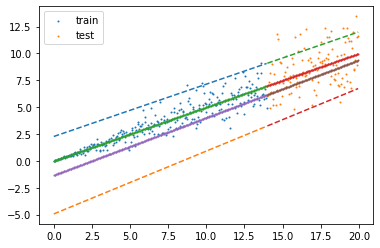

In [35]:
# do not forget to use eval mode as we are using batch norm layers
model.eval()

plt.scatter(x_train, y_train, s=1, label="train")
plt.scatter(x_test, y_test, s=1, label="test")
plt.scatter(x_train, y_true_train, s=1)
plt.scatter(x_test, y_true_test, s=1)

train_dist = model(x_train)
train_mean = train_dist.mean.detach().numpy().squeeze()
train_std = train_dist.stddev.detach().numpy().squeeze()

plt.scatter(x_train, train_mean, s=1)
plt.plot(x_train.numpy(), train_mean+2*train_std, linestyle="--")
plt.plot(x_train.numpy(), train_mean-2*train_std, linestyle="--")

test_dist = model(x_test)
test_mean = test_dist.mean.detach().numpy().squeeze()
test_std = test_dist.stddev.detach().numpy().squeeze()

plt.scatter(x_test, test_mean, s=1)
plt.plot(x_test.numpy(), test_mean+2*test_std, linestyle="--")
plt.plot(x_test.numpy(), test_mean-2*test_std, linestyle="--")

plt.legend()